# Bruins/Celtics Game Analysis

This file examines post-game entries at North Station station in comparison to expectations.

## Setup

In [4]:
# Libraries.
import datetime as dt
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Feature libraries.
from features import date

In [5]:
# Package settings.

# Matplotlib.
%matplotlib inline

# Seaborn.
sns.set_style('darkgrid')

In [47]:
# Other settings.

# Stations near TD Garden for analysis. Just use names (not locationid) as a surrogate key for station.
td_stations = ['North Station']

# Base units of timedeltas.
timedelta_base = 3.6e12

# Default figure size.
default_figsize = (12,8)

# Day of week mapping.
days_of_week = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

# Game lengths in hours for coloring.
game_lengths = {
    'Celtics': 2.25,
    'Bruins':  2.3333
}

# Team colors.
team_colors = {
    'Bruins': '#FDB930',
    'Celtics': '#008348'
}

## Data

### Read Bruins

In [7]:
# Read Red Sox home games.
bruins = pd.DataFrame.from_csv("../../../data/bruins/home.csv").reset_index(drop=False)

# Drop home/playoff columns.
bruins.drop(['Home','Playoff'], axis=1, inplace=True)

# Rename other columns to make joining easy.
bruins.rename(columns={'Datetime':'game_datetime', 'Opponent':'opponent'}, inplace=True)

# Get standalone game date.
bruins['game_date'] = pd.to_datetime(pd.DatetimeIndex(bruins.game_datetime).date)

# Turn game date/time into an appropriate object.
# bruins.game_datetime = pd.to_datetime(bruins.game_datetime)

# Add game time column.
bruins['game_time'] = pd.DatetimeIndex(bruins.game_datetime).time

# Add sport column for later merging.
bruins['team'] = 'Bruins'

In [ ]:
bruins.head()

### Read Celtics

In [8]:
# Read Red Sox home games.
celtics = pd.DataFrame.from_csv("../../../data/celtics/home.csv").reset_index(drop=False)

# Drop home/playoff columns.
celtics.drop(['Home','Playoff'], axis=1, inplace=True)

# Rename other columns to make joining easy.
celtics.rename(columns={'Datetime':'game_datetime', 'Opponent':'opponent'}, inplace=True)

# Get standalone game date. There must be a better way, but this works for now.
celtics['game_date'] = pd.to_datetime(pd.DatetimeIndex(celtics.game_datetime).date)

# Turn game date/time into an appropriate object.
# celtics.game_datetime = pd.to_datetime(celtics.game_datetime)

# Add game time column.
celtics['game_time'] = pd.DatetimeIndex(celtics.game_datetime).time

# Add sport column for later merging.
celtics['team'] = 'Celtics'

In [ ]:
celtics.head()

### Read Entries

In [9]:
# Import gatecount data.
def get_data():
    return pd.DataFrame.from_csv("../../../data/mbta.csv").reset_index()
gatecount = date.init(get_data())

# Restrict to desired stations and the columns that we need.
td_gatecount = gatecount.ix[gatecount.name.isin(td_stations),['locationid','name','service_day','service_datetime','entries']].reset_index(drop=True)

# Turn days/dates into datetimes.
td_gatecount.service_day = pd.to_datetime(td_gatecount.service_day)
td_gatecount.service_datetime = pd.to_datetime(td_gatecount.service_datetime)

# Get time of day.
td_gatecount['service_time'] = pd.DatetimeIndex(td_gatecount.service_datetime).time

# Add day of week.
td_gatecount = date.add_day_of_week(td_gatecount.copy())

# Drop gatecount.
del gatecount

### Merge

In [10]:
# Merge all games.
games = bruins.append(celtics)

# Get teams set for later traversal.
teams = set(games.team)

In [11]:
# Perform merge.
td_games = td_gatecount.merge(games, left_on='service_day', right_on='game_date', how='left')

# Flag days with games.
td_games['game_played'] = td_games.team.isnull() == False

# Calculate delta from game start to entries record time.
td_games['time_since_game_start'] = td_games.service_datetime - td_games.game_datetime

In [ ]:
td_games[td_games.game_played].head()

## Game Exploration

In [27]:
# For reference, how many days have two games?
date_games = games.groupby('game_date').agg({'team': len}).rename(columns={'team':'games'})
print 'Days with more than two games:',(date_games.games >= 2).sum()

Days with more than two games: 8


Let's figure out when games happen.

In [28]:
# Copy DF for this analysis.
games_only = games.copy()
# Add weekday.
games_only['day_of_week'] = pd.DatetimeIndex(games_only.game_date).weekday

When do games occur during the week? We might expect a consistent pattern as the teams share an arena and their seasons largely overlap. **Monday is 0.**

In [49]:
# Summarize by team-DoW.
games_by_team_dow = games_only.groupby(['team','day_of_week']).agg({'game_time':len}).reset_index()
games_by_team_dow.rename(columns={'game_time':'games'}, inplace=True)
# games_by_team_dow

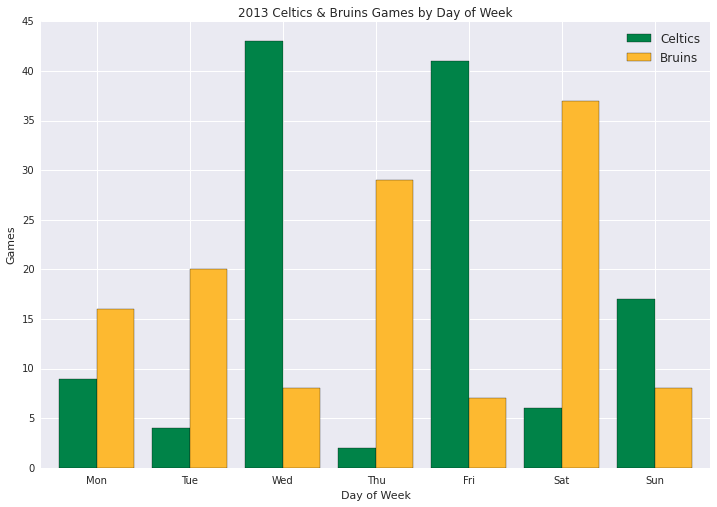

In [94]:
# Plot days of week.

# Start plotting.
plt.figure(figsize=default_figsize)
for i, team in enumerate(set(games_by_team_dow.team)):
    team_games = games_by_team_dow[games_by_team_dow.team == team].sort('day_of_week')
    plt.bar(np.arange(0,7)+(i*0.4), team_games.games, width=0.4, color=team_colors[team], label=team)

# Prettify.
plt.title('2013 Celtics & Bruins Games by Day of Week')
plt.xlabel('Day of Week'); plt.ylabel('Games')
plt.xlim(-0.2,7)
plt.xticks(np.arange(0,7)+0.4, days_of_week)
plt.legend(fontsize='large')

# Show.
plt.show()

Aha! Hockey mostly takes Tuesday/Thursday/Saturday; Basketball takes Wednesday/Friday/Sunday. Looks like the Bruins have a slight edge on Monday too.

What about during the day?

In [59]:
# Group and aggregate by time.
games_by_team_time = games_only.groupby(['team','game_time']).agg({'opponent':len}).reset_index()
games_by_team_time.rename(columns={'opponent':'games'}, inplace=True)
# games_by_team_time

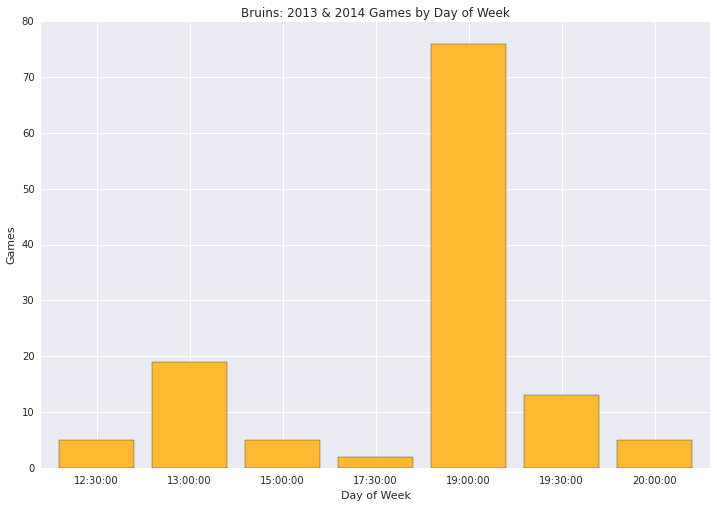

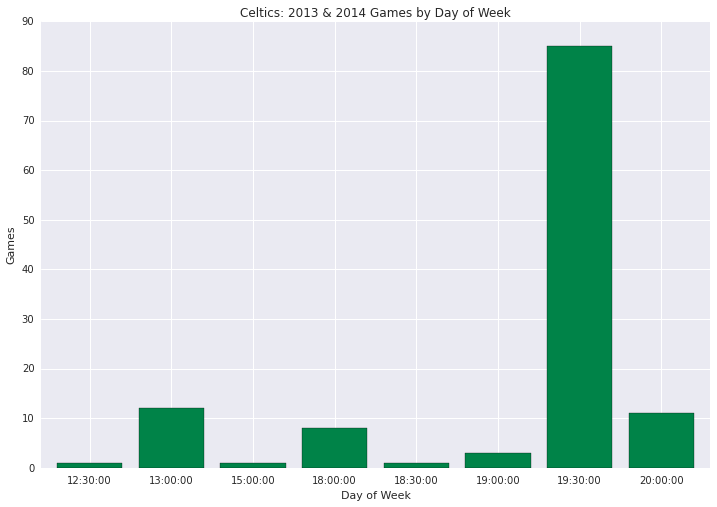

In [72]:
# Plot times. Once per team.

for team in sorted(set(games_by_team_time.team)):
    # Get team times.
    team_times = games_by_team_time[games_by_team_time.team == team]
    # Plot.
    plt.figure(figsize=default_figsize)
    plt.bar(np.arange(len(team_times)), team_times.games, width=0.8, color=team_colors[team])
    # Prettify.
    plt.title('%s: 2013 & 2014 Games by Day of Week' % team)
    plt.xlabel('Day of Week'); plt.ylabel('Games')
    plt.xticks(np.arange(0,len(team_times))+0.4, np.array(team_times.game_time))
    plt.xlim(-0.2,len(team_times))
    # Show.
    plt.show()

Now combine the above.

In [13]:
# Group and aggregate by time.
games_by_datetime = games_only.groupby(['team','day_of_week','game_time']).agg({'opponent':len})
games_by_datetime.columns = ['games']
games_by_datetime

games
team    day_of_week game_time       
Bruins  0           13:00:00       4
                    15:00:00       1
                    19:00:00       7
                    19:30:00       2
                    20:00:00       2
        1           19:00:00      18
                    19:30:00       2
        2           19:00:00       3
                    19:30:00       3
                    20:00:00       2
        3           19:00:00      26
                    19:30:00       3
        4           13:00:00       1
                    19:00:00       4
                    19:30:00       1
                    20:00:00       1
        5           12:30:00       3
                    13:00:00      14
                    15:00:00       2
                    17:30:00       2
                    19:00:00      16
        6           12:30:00       2
                    15:00:00       2
                    19:00:00       2
                    19:30:00       2
Celtics 0           19:30:00       8
                    20:00:00       1
        1           13:00:00       1
                    19:00:00       1
                    19:30:00       2
        2           13:00:00       1
                    19:30:00      37
                    20:00:00       5
        3           20:00:00       2
        4           13:00:00       2
                    19:00:00       1
                    19:30:00      36
                    20:00:00       2
        5           12:30:00       1
                    13:00:00       2
                    19:30:00       2
                    20:00:00       1
        6           13:00:00       6
                    15:00:00       1
                    18:00:00       8
                    18:30:00       1
                    19:00:00       1

Overall, things look *pretty* consistent. For modeling, we'll have to find a way to handle some of the very uncommon cases (e.g., a Celtics game on a Tuesday).

## Game/Entries Exploration

### Aggregate

Let's look for entry changes during and after games conditional on day of week and time of day. E.g., how do entries during a Celtics game at 1pm on Thursday relate to non-game days. We'll examine games in the aggregate for both sports first.

In [12]:
# Get hourly entries for all days and times of day on gameless days. Use name to indicate stations.
gameless_entries_dow = td_games[td_games.game_played == False]
gameless_entries_dow = gameless_entries_dow.groupby(['name','day_of_week','service_time']).agg({'entries': np.mean}).reset_index()
gameless_entries_dow.rename(columns={'entries':'mean_entries'}, inplace=True)

In [13]:
# Only consider entries at the time of or soon after the game.
gametime_condition = (td_games.time_since_game_start >= np.timedelta64(-30,'m')) & (td_games.time_since_game_start <= np.timedelta64(5,'h'))
# Apply above conditions.
game_entries_dow = td_games[td_games.game_played & gametime_condition]

# Join mean entries for gameless days at that time of day.
entry_differences_dow = game_entries_dow.merge(gameless_entries_dow, on=['name','day_of_week','service_time'])[['team','name','game_date','day_of_week','game_time','entries','time_since_game_start','mean_entries']]
entry_differences_dow['entries_vs_mean'] = entry_differences_dow.entries - entry_differences_dow.mean_entries
entry_differences_dow['entries_vs_mean_ratio'] = entry_differences_dow.entries / entry_differences_dow.mean_entries

# Calculate mean differences and clean up timedeltas that don't place nicely with groupings.
mean_entry_differences_dow = entry_differences_dow.groupby(['team','name','day_of_week','game_time','time_since_game_start']).agg({
        'entries_vs_mean': [np.mean,np.std],
        'entries_vs_mean_ratio': [np.mean,np.std]
    }).reset_index()
mean_entry_differences_dow.time_since_game_start = pd.to_timedelta(mean_entry_differences_dow.time_since_game_start)
mean_entry_differences_dow['hours_since_game_start'] = mean_entry_differences_dow.time_since_game_start.astype(np.int) / timedelta_base

In [ ]:
mean_entry_differences_dow

Note that some standard deviations above are NaNs because of game day-times that only occurred once.

In [14]:
# The hierarchical columns are a pain here. Flatten them.
mean_entry_differences_dow_copy = mean_entry_differences_dow.copy()
cols = mean_entry_differences_dow.columns.get_level_values(0).tolist()
for i, c in enumerate(mean_entry_differences_dow.columns.get_level_values(1)):
    if c != '':
        cols[i] += '_' + c
mean_entry_differences_dow_copy.columns = cols

# Summarize.
mean_entry_differences_summarized = mean_entry_differences_dow_copy.groupby(['team','hours_since_game_start']).agg({
    'entries_vs_mean_mean': np.mean,
    'entries_vs_mean_std':  np.std
}).reset_index()

In [ ]:
mean_entry_differences_summarized

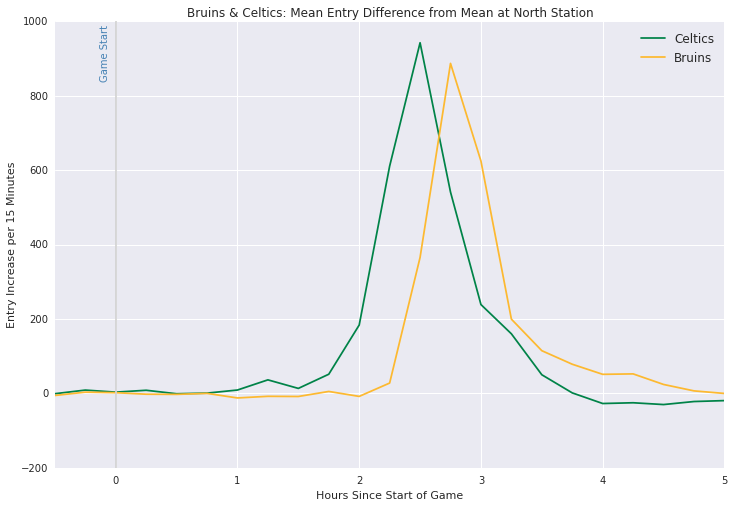

In [76]:
# Plot means for each team.
plt.figure(figsize=default_figsize)
for team in teams:
    plt.plot(mean_entry_differences_summarized[mean_entry_differences_summarized.team == team].hours_since_game_start, mean_entry_differences_summarized[mean_entry_differences_summarized.team == team].entries_vs_mean_mean, label=team, color=team_colors[team])

# Fix x limit and add origin lines.
xlim = plt.xlim((-0.5, plt.xlim()[1])); ylim = plt.ylim()
plt.axvline(0, *ylim, color='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (-.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

# Prettify.
plt.title('Bruins & Celtics: Mean Entry Difference from Mean at North Station')
plt.xlabel('Hours Since Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
plt.xlim(xlim)
plt.legend(fontsize='large')

# Show.
plt.show()

Basketball entries peak ~2.5 hours after game start; hockey entries peak 15 minutes later.

In [73]:
# Sums.
mean_entry_differences_summarized[['team','entries_vs_mean_mean']].rename(columns={'entries_vs_mean_mean':'mean_entries'}).groupby(['team']).agg({'mean_entries':np.sum})

,mean_entries
team,
Bruins,2395.970489
Celtics,2735.385846


Compared to typical entries for the same day and time, Celtics games appear to produce **~2,735** additional entries; Bruins games produce **~2,396** additional entries. 

### Aggregate Distribution

In [78]:
# We can reuse some tables from above. game_entries_dow will suit our needs but we'll need to derive another df for games.

# Only consider entries at the time of or soon after the game.
gametime_condition = (td_games.time_since_game_start >= np.timedelta64(-30,'m')) & (td_games.time_since_game_start <= np.timedelta64(5,'h'))
all_games_entries = td_games[td_games.game_played & gametime_condition]

# Get differences from means.
entry_differences_fields = ['team','game_date','entries','mean_entries']
entry_differences_per_game = all_games_entries.merge(gameless_entries_dow, on=['name','day_of_week','service_time'])[entry_differences_fields]
entry_differences_per_game['entries_vs_mean'] = entry_differences_per_game.entries - entry_differences_per_game.mean_entries

# Now aggregate by team, and sum entries vs. mean.
agg_entry_differences = entry_differences_per_game.groupby(['team','game_date']).agg({'entries_vs_mean': np.sum}).reset_index()

In [ ]:
agg_entry_differences

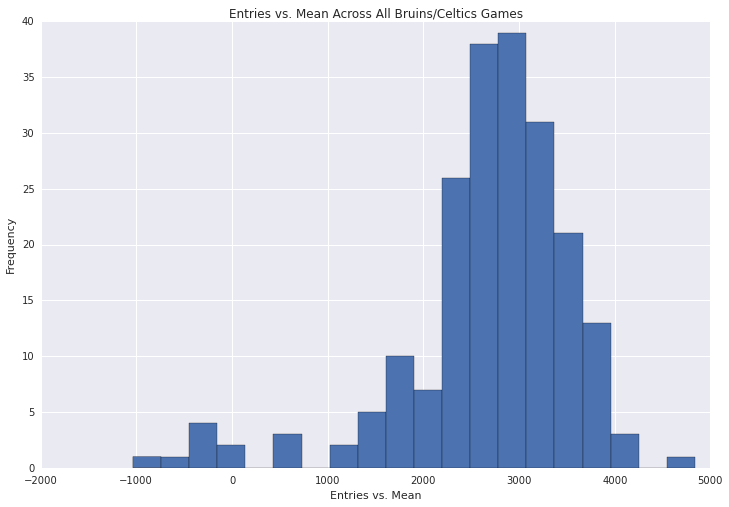

In [89]:
# Plot aggregate.
plt.figure(figsize=default_figsize)
plt.hist(agg_entry_differences.entries_vs_mean, stacked=True, bins=20)
# Prettify.
plt.title('Entries vs. Mean Across All Bruins/Celtics Games')
plt.xlabel('Entries vs. Mean'); plt.ylabel('Frequency')
# Show.
plt.show()

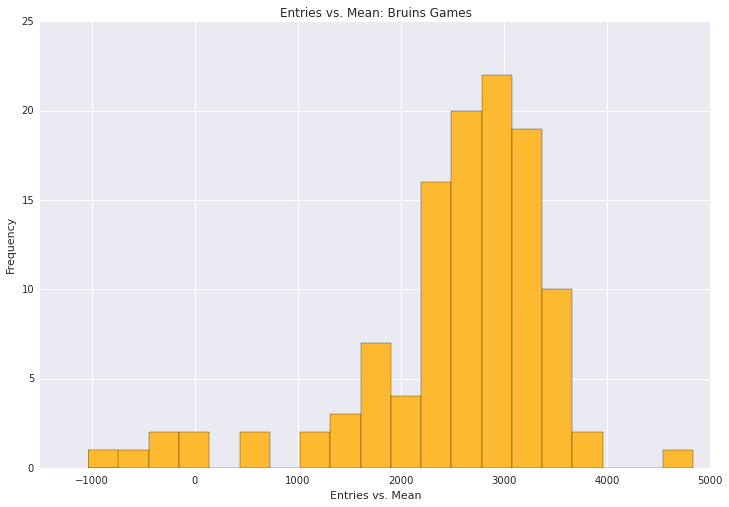

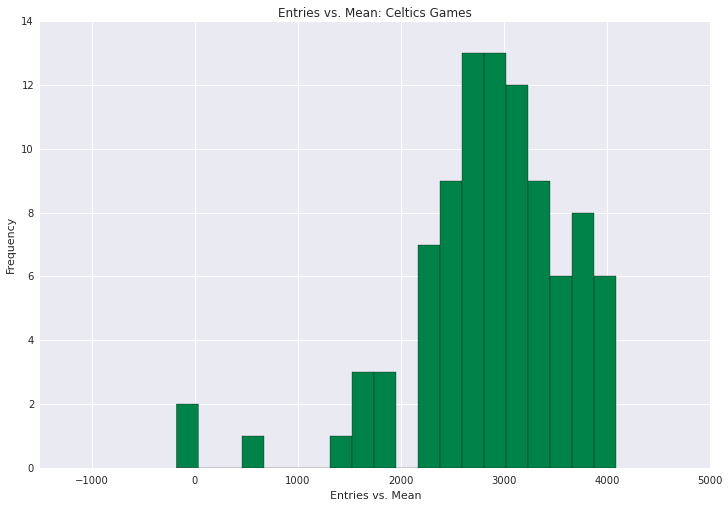

In [90]:
# Plot each team.
for team in teams:
    plt.figure(figsize=default_figsize)
    plt.hist(agg_entry_differences.entries_vs_mean[agg_entry_differences.team == team].tolist(), bins=20, label=team, color=team_colors[team])
    # Prettify.
    plt.title('Entries vs. Mean: %s Games' % team)
    plt.xlabel('Entries vs. Mean'); plt.ylabel('Frequency')
    plt.xlim(-1500,5000)
    # Show.
    plt.show()

What's the deal with some of those outliers?

In [31]:
agg_entry_differences.sort('entries_vs_mean').head()

,team,game_date,entries_vs_mean
1,Bruins,2013-01-21,-1036.413793
51,Bruins,2013-11-29,-575.859792
113,Bruins,2015-02-10,-420.491161
57,Bruins,2013-12-31,-206.996178
196,Celtics,2014-12-26,-177.859792


In order, those dates were: MLK Day, the day after Thanksgiving, a service interruption, NYE, and the day after Christmas.